<a href="https://colab.research.google.com/github/jmsmg/TIL/blob/main/%ED%94%84%EB%A1%9C%EC%A0%9D%ED%8A%B8/Midproject_%EC%98%81%ED%99%94%20%EC%B6%94%EC%B2%9C%20%EC%8B%9C%EC%8A%A4%ED%85%9C/mid-project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. 분석 주제 및 데이터 소개

### ○ 분석 주제

① 다양한 '영화 추천 시스템'을 코드로 구현해보고, 직접 수집한 데이터 목록에 적용해본다

② 추천 시스템의 유형

    1) 콘텐츠 기반 필터링 : 특정 장르, 줄거리 기반 영화 추천

    2) 협업 필터링 : "취향이 비슷한 친구에게 물어보기"
   
        2-1) 최근접 이웃(Nearest Neighbor) 협업 필터링
           
            * 사용자 기반(User-User): "당신과 비슷한 고객들은 다음 상품도 구매했습니다" 
            * 아이템 기반(Item-Item): "이 상품을 선택한 다른 고객들은 다음 상품도 구매했습니다"
    
        2-2) 잠재 요인(Latent Factor) 협업 필터링 : 넷플릭스 추천 엔진 경연 대회 우승 모델
        
③ 영화 별점에 영향을 미치는 요인들을 분석해보고 고객이 새로운 영화를 만났을 때 별점을 예측해본다.

### ○ 데이터 소개

① 'The Movies Dataset': 콘텐츠 기반 필터링

 https://www.kaggle.com/rounakbanik/the-movies-dataset?select=movies_metadata.csv
 
 ![nn](https://github.com/jmsmg/TIL/blob/main/%ED%94%84%EB%A1%9C%EC%A0%9D%ED%8A%B8/Midproject_%EC%98%81%ED%99%94%20%EC%B6%94%EC%B2%9C%20%EC%8B%9C%EC%8A%A4%ED%85%9C/Dataset.png?raw=1)

② 'MovieLens': 협업 필터링

https://grouplens.org/datasets/movielens/latest/

![nn](https://github.com/jmsmg/TIL/blob/main/%ED%94%84%EB%A1%9C%EC%A0%9D%ED%8A%B8/Midproject_%EC%98%81%ED%99%94%20%EC%B6%94%EC%B2%9C%20%EC%8B%9C%EC%8A%A4%ED%85%9C/movielens.png?raw=1)

③ 네이버 영화 랭킹: 데이터 수집

![nn](https://github.com/jmsmg/TIL/blob/main/%ED%94%84%EB%A1%9C%EC%A0%9D%ED%8A%B8/Midproject_%EC%98%81%ED%99%94%20%EC%B6%94%EC%B2%9C%20%EC%8B%9C%EC%8A%A4%ED%85%9C/naver.png?raw=1)

---

<br>

In [29]:
!pip install selenium

In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import time

from PIL import Image
from ast import literal_eval # 문자열 -> 리스트나 딕셔너리로 변환해주는 라이브러리

from urllib.request import urlopen 
from bs4 import BeautifulSoup

from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys

<br>

# 2. 영화 추천 시스템

## 2-1. 콘텐츠 기반 필터링

### 장르별 단순 추천 시스템

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# 필요한 칼럼 추출

movies = pd.read_csv('/content/gdrive/MyDrive/Datasets/data/movies_metadata.csv')
movies_1 = movies[['imdb_id','original_title','genres','overview','vote_average','vote_count']]

#### 데이터 전처리

##### 가중치 점수 column 생성

In [ ]:
# 가중치 부여 전
before = movies_1[['original_title','vote_average','vote_count']]

# sort_values 함수로 vote_average을 내림차순 진행하여 데이터 확인
before.sort_values('vote_average', ascending=False).head()

# vote_count가 너무 적으면 의미 없는 데이터 (Outlier)

,original_title,vote_average,vote_count
21642,Ice Age Columbus: Who Were the First Americans?,10.0,1.0
15710,If God Is Willing and da Creek Don't Rise,10.0,1.0
22396,Meat the Truth,10.0,1.0
22395,Marvin Hamlisch: What He Did For Love,10.0,1.0
35343,Elaine Stritch: At Liberty,10.0,1.0


###### 시각화 (평균 평점, 투표수 확인)

- 평균 점수가 10점이나, 투표수가 1개임 => 1명이 10점 투표함(의미없는 데이터)

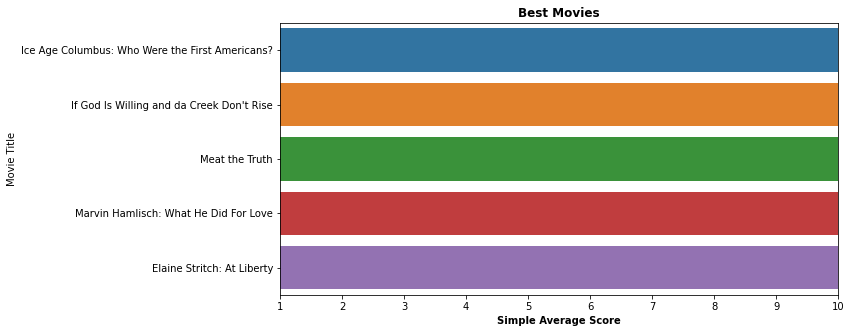

In [ ]:
vote_score = movies_1.sort_values('vote_average', ascending=False)
plt.figure(figsize=(10,5)) 
axis1=sns.barplot(x=vote_score['vote_average'].head(), y=vote_score['original_title'].head(), data=vote_score)
           
plt.xlim(1,10)
plt.title('Best Movies', weight='bold')
plt.xlabel('Simple Average Score', weight='bold')
plt.ylabel('Movie Title')
plt.savefig('best_movies.png')

##### 데이터 정규화
- IMDB에서 사용하는 가중치 공식 (imdb's weighted rating formula)

![nn](https://images.tutorialedge.net/images/python/recommender-system-python/image2-19.png)

- V: 영화의 득표수
- m: 차트에 나열되기 위한 최소한의 득표수
- R: 영화의 평균 평점
- C: 전체 차트의 평균 평점

In [ ]:
# 가중치 부여
vote_counts = movies_1[movies_1['vote_count'].notnull()]['vote_count'].astype('int')
vote_averages = movies_1[movies_1['vote_average'].notnull()]['vote_average'].astype('int')

In [ ]:
C = vote_averages.mean() 
m = vote_counts.quantile(0.95)  # 백분위 95 (득표수가 5% 안에 들어야 차트 안에 진입 가능)

def weighted_rating(x):
    v = x['vote_count'] # 득표수
    R = x['vote_average'] # 평균 평점
    return (v/(v+m) * R) + (m/(m+v) * C) # IMDB 실제 공식이 홈페이지에 나와있음


# 가중치 공식을 대입하여 ['weighted']을 생성
movies_1['weighted'] = movies_1.apply(weighted_rating, axis=1)

In [ ]:
# 가중치 부여 후
after=movies_1[['original_title','vote_average','vote_count','weighted']]
after.head()

,original_title,vote_average,vote_count,weighted
0,Toy Story,7.7,5415.0,7.517830
1,Jumanji,6.9,2413.0,6.647694
2,Grumpier Old Men,6.5,92.0,5.464420
3,Waiting to Exhale,6.1,34.0,5.307020
4,Father of the Bride Part II,5.7,173.0,5.374605


###### 시각화(가중치 점수로 내림차순)

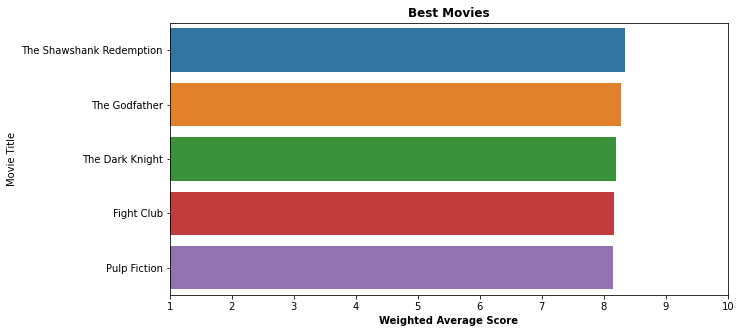

In [ ]:
weight_average=movies_1.sort_values('weighted', ascending=False)
plt.figure(figsize=(10,5)) 
axis1=sns.barplot(x=weight_average['weighted'].head(), y=weight_average['original_title'].head(), data=weight_average)

           
plt.xlim(1,10)
plt.title('Best Movies', weight='bold')
plt.xlabel('Weighted Average Score', weight='bold')
plt.ylabel('Movie Title')
plt.savefig('best_movies.png')

![image](https://github.com/jmsmg/TIL/blob/main/%ED%94%84%EB%A1%9C%EC%A0%9D%ED%8A%B8/Midproject_%EC%98%81%ED%99%94%20%EC%B6%94%EC%B2%9C%20%EC%8B%9C%EC%8A%A4%ED%85%9C/image/best_movies2.png?raw=1)

#### 장르별 추천 프로세스

In [ ]:
movies_1['genres'] # ['genres'] 칼럼의 내용이 json 형태로 존재함

0        [{'id': 16, 'name': 'Animation'}, {'id': 35, '...
1        [{'id': 12, 'name': 'Adventure'}, {'id': 14, '...
2        [{'id': 10749, 'name': 'Romance'}, {'id': 35, ...
3        [{'id': 35, 'name': 'Comedy'}, {'id': 18, 'nam...
4                           [{'id': 35, 'name': 'Comedy'}]
                               ...                        
45461    [{'id': 18, 'name': 'Drama'}, {'id': 10751, 'n...
45462                        [{'id': 18, 'name': 'Drama'}]
45463    [{'id': 28, 'name': 'Action'}, {'id': 18, 'nam...
45464                                                   []
45465                                                   []
Name: genres, Length: 45466, dtype: object

In [ ]:
a = movies_1['genres'].fillna('[]').apply(literal_eval).apply(lambda x: [i['name'] for i in x])
a

0         [Animation, Comedy, Family]
1        [Adventure, Fantasy, Family]
2                   [Romance, Comedy]
3            [Comedy, Drama, Romance]
4                            [Comedy]
                     ...             
45461                 [Drama, Family]
45462                         [Drama]
45463       [Action, Drama, Thriller]
45464                              []
45465                              []
Name: genres, Length: 45466, dtype: object

In [ ]:
#딕셔너리에서 키값 가져오기
# literal_eval: 문자열을 딕셔너리/리스트 형태로 변환해줌
# isinstance(instance, 클래스/데이터타입) : 인스턴스가 특정 클래스/데이터 타입과 일치할 경우에는 True, 아닌 경우에는 False를 리턴
# isinstance 관련 링크 https://brownbears.tistory.com/155

movies_1['genres'] = movies_1['genres'].fillna('[]').apply(literal_eval).apply(lambda x: [i['name'] for i in x] # x에 ['name'] i번 x를 대입하여
                                                                           if isinstance(x, list) else []) # (x가 list형태일치하는지 확인)

In [ ]:
movies_1[['original_title','genres']].head()

,original_title,genres
0,Toy Story,"[Animation, Comedy, Family]"
1,Jumanji,"[Adventure, Fantasy, Family]"
2,Grumpier Old Men,"[Romance, Comedy]"
3,Waiting to Exhale,"[Comedy, Drama, Romance]"
4,Father of the Bride Part II,[Comedy]


In [32]:
a = movies_1.apply(lambda x: pd.Series(x['genres']),axis=1)
a

,0,1,2,3,4,5,6,7
0,Animation,Comedy,Family,NaN,NaN,NaN,NaN,NaN
1,Adventure,Fantasy,Family,NaN,NaN,NaN,NaN,NaN
2,Romance,Comedy,NaN,NaN,NaN,NaN,NaN,NaN
3,Comedy,Drama,Romance,NaN,NaN,NaN,NaN,NaN
4,Comedy,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
45461,Drama,Family,NaN,NaN,NaN,NaN,NaN,NaN
45462,Drama,NaN,NaN,NaN,NaN,NaN,NaN,NaN
45463,Action,Drama,Thriller,NaN,NaN,NaN,NaN,NaN
45464,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [34]:
pd.DataFrame.reset_index?

In [42]:
# 하나의 영화가 복수의 장르에 속함
# 하나하나 꺼내서 g에 데이터 저장
# stack() 위아래로 재배치 , unstack 왼쪽에서 오른쪽 재배치 https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.stack.html

g = movies_1.apply(lambda x: pd.Series(x['genres']),axis=1).stack().reset_index(level=1, drop=True)
g.head(10)

0    Animation
0       Comedy
0       Family
1    Adventure
1      Fantasy
1       Family
2      Romance
2       Comedy
3       Comedy
3        Drama
dtype: object

In [44]:
pandas.series.name?

Object `pandas.series.name` not found.


In [45]:
# 기존의 'genres'는 삭제하고,새로운 genre인 g를 집어넣음

g.name = 'genre'
gen_movies = movies_1.drop('genres', axis=1).join(g)
gen_movies.head()

,imdb_id,original_title,overview,vote_average,vote_count,weighted,genre
0,tt0114709,Toy Story,"Led by Woody, Andy's toys live happily in his ...",7.7,5415.0,7.517830,Animation
0,tt0114709,Toy Story,"Led by Woody, Andy's toys live happily in his ...",7.7,5415.0,7.517830,Comedy
0,tt0114709,Toy Story,"Led by Woody, Andy's toys live happily in his ...",7.7,5415.0,7.517830,Family
1,tt0113497,Jumanji,When siblings Judy and Peter discover an encha...,6.9,2413.0,6.647694,Adventure
1,tt0113497,Jumanji,When siblings Judy and Peter discover an encha...,6.9,2413.0,6.647694,Fantasy


In [46]:
#장르별 추천함수 만들기

def genre_chart(genre,percentile=0.95):
   
    df=gen_movies[gen_movies['genre'] == genre]
    vote_counts=df[df['vote_count'].notnull()]['vote_count'].astype(int)
    vote_averages=df[df['vote_average'].notnull()]['vote_average'].astype(int)
  
    c=vote_averages.mean()
    m=vote_counts.quantile(percentile)
    
    qualified=df[df['vote_count'].notnull() & df['vote_average'].notnull()][['original_title','vote_count','vote_average']]
    qualified['weighted'] = qualified.apply(lambda x: (x['vote_count']/(x['vote_count']+m) * x['vote_average']) + (m/(m+x['vote_count']) * C), axis=1)
    qualified = qualified.sort_values('weighted', ascending=False).head(100)
    
    return qualified

#### 결과 해석

In [51]:
genre_chart('Animation').head()

,original_title,vote_count,vote_average,weighted
5481,千と千尋の神隠し,3968.0,8.3,7.531736
359,The Lion King,5520.0,8.0,7.464079
30315,Inside Out,6737.0,7.9,7.461417
13724,Up,7048.0,7.8,7.393597
12704,WALL·E,6439.0,7.8,7.361753


<br>

### ○ 줄거리 기반 추천 시스템 (tf-idf)

#### 데이터 전처리 및 분석

In [52]:
# 결측치 확인
movies_2 = movies[['imdb_id', 'original_title', 'original_language', 'overview', 'runtime', 'vote_average', 'production_companies']]
movies_2.isnull().sum()


imdb_id                  17
original_title            0
original_language        11
overview                954
runtime                 263
vote_average              6
production_companies      3
dtype: int64

In [53]:
# 결측치 제거 및 재확인

movies_2 = movies_2.dropna()
print('Null 값 개수 :', movies_2['overview'].isnull().sum())

Null 값 개수 : 0


- ratings 히스토그램

Text(0, 0.5, 'Ratings')

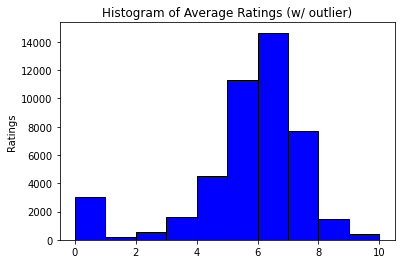

In [54]:
# matplotlib histogram
plt.hist(movies['vote_average'], color = 'blue', edgecolor = 'black')

# Add labels
plt.title('Histogram of Average Ratings (w/ outlier)')
plt.ylabel('Ratings')

![image](https://github.com/jmsmg/TIL/blob/main/%ED%94%84%EB%A1%9C%EC%A0%9D%ED%8A%B8/Midproject_%EC%98%81%ED%99%94%20%EC%B6%94%EC%B2%9C%20%EC%8B%9C%EC%8A%A4%ED%85%9C/image/rating_hist.png?raw=1)

- runtime 히스토그램 (이상치 제거 전)

Text(0, 0.5, 'Runtime (min)')

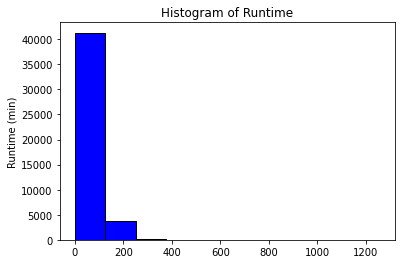

In [55]:
movies.runtime = movies.runtime.astype(float)

# matplotlib histogram
plt.hist(movies['runtime'], color = 'blue', edgecolor = 'black')

# Add labels
plt.title('Histogram of Runtime')
plt.ylabel('Runtime (min)')

![image.png](https://github.com/jmsmg/TIL/blob/main/%ED%94%84%EB%A1%9C%EC%A0%9D%ED%8A%B8/Midproject_%EC%98%81%ED%99%94%20%EC%B6%94%EC%B2%9C%20%EC%8B%9C%EC%8A%A4%ED%85%9C/image/runtime_hist.png?raw=1)

In [56]:
movies[movies.runtime == movies.runtime.max()]

,adult,belongs_to_collection,budget,genres,homepage,id,imdb_id,original_language,original_title,overview,popularity,poster_path,production_companies,production_countries,release_date,revenue,runtime,spoken_languages,status,tagline,title,video,vote_average,vote_count
24178,False,NaN,0,"[{'id': 18, 'name': 'Drama'}, {'id': 36, 'name...",NaN,67493,tt0076993,en,Centennial,The economic and cultural growth of Colorado s...,0.664727,/AoEgJrDVkzlgWugcaTxI03FiUXf.jpg,"[{'name': 'Universal Television', 'id': 26727}]","[{'iso_3166_1': 'US', 'name': 'United States o...",1978-10-01,0.0,1256.0,[],Released,NaN,Centennial,False,7.9,8.0


In [57]:
# remove outliers (+- 3 stdv from mean)
# abs는 절대값처리(런타임은 -가 없음)
# 런타임 - 런타임 평균 <= 3*런타임 표준편차 시그마 3이상 떨어진 값 제거
movies_df = movies_2[np.abs(movies_2.runtime-movies_2.runtime.mean()) <= (3*movies_2.runtime.std())]
movies_df = movies_df.reset_index(drop = True)

- runtime 히스토그램 (이상치 제거 후)

Text(0, 0.5, 'Runtime (min)')

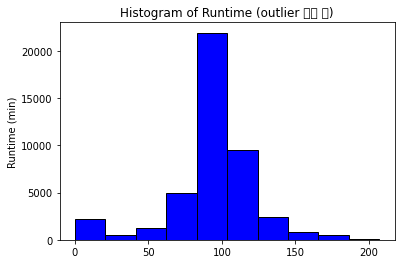

In [58]:
# matplotlib histogram
plt.hist(movies_df['runtime'], color = 'blue', edgecolor = 'black')

# Add labels
plt.title('Histogram of Runtime (outlier 제거 후)')
plt.ylabel('Runtime (min)')

![image.png](https://github.com/jmsmg/TIL/blob/main/%ED%94%84%EB%A1%9C%EC%A0%9D%ED%8A%B8/Midproject_%EC%98%81%ED%99%94%20%EC%B6%94%EC%B2%9C%20%EC%8B%9C%EC%8A%A4%ED%85%9C/image/runtime_hist2.png?raw=1)

#### 텍스트 데이터 분석

In [59]:
from sklearn.feature_extraction.text import TfidfVectorizer

corpus = movies_df.overview.tolist() # pd series to list
vectorizer = TfidfVectorizer(stop_words='english', min_df=0.0005) # setting min_df (memory issue)
tfidf = vectorizer.fit_transform(corpus).todense()
tfidf_df = pd.DataFrame(tfidf)

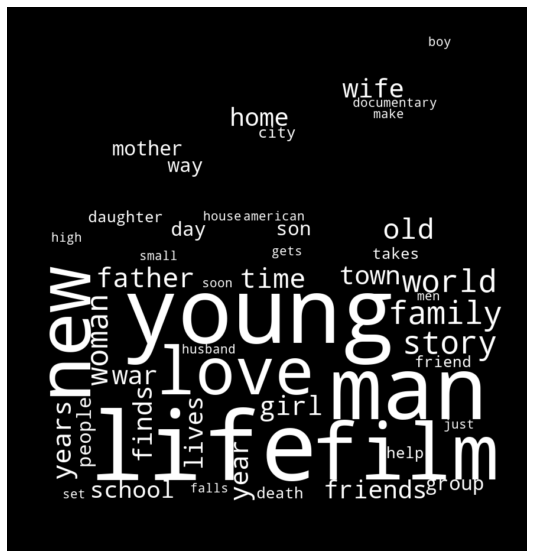

In [75]:
## visualization
from wordcloud import WordCloud
from PIL import Image

feature_names = vectorizer.get_feature_names()
words = pd.DataFrame(tfidf, columns=feature_names)
words_t = words.T.sum(axis=1)
movie_mask = np.array(Image.open("/content/gdrive/MyDrive/Datasets/data/image/movie_clip.png"))
cloud = WordCloud(background_color="black", max_words=50, mask=movie_mask, color_func=lambda *args, **kwargs: "white").generate_from_frequencies(words_t)
plt.figure(figsize=(20,10))
plt.imshow(cloud, interpolation="bilinear")
plt.axis("off")
plt.show()

#### Cosine Similarity

In [66]:
from sklearn.metrics.pairwise import cosine_similarity

# ex to see if the model works
print("Similarity between", movies_df.original_title[0], "and", movies_df.original_title[1], " : ", cosine_similarity(tfidf[0], tfidf[1]))

Similarity between Toy Story and Jumanji  :  [[0.01893468]]


#### 영화 추천

In [67]:
def cos_sim(a, b):
    return float(cosine_similarity(a,b))

In [73]:
import random

# user input 넘버로 영화 추천 (랜덤)
user_num = int(input("숫자를 입력하세요: "))
random.seed(user_num)
rand_mov_idx = random.randint(0, len(movies_df) - 1) # 0 to (number of movies - 1) --- inclusive # randint 함수는 들어온 인자 사이 값을 랜덤으로 뱉어냄
rand_mov_title = movies_df.original_title[rand_mov_idx]
print("오늘의 추천 영화는: ", rand_mov_title, "입니다.")

숫자를 입력하세요: 3
오늘의 추천 영화는:  The Street with No Name 입니다.


In [74]:
def similar_movie(index,rank=10):
    scorelist = []
    movielist = []
    
    for i in range(len(tfidf_df)):
        if i != index:
            scorelist.append((cos_sim(tfidf[i],tfidf[index]),i))
    scorelist.sort()
    scorelist.reverse()
    scorelist = scorelist[:rank]
    
    for score, index in scorelist:
        movielist.append([index,score, movies_df['original_title'][index]])
    
    return movielist

In [76]:
similar_movie(0) # 토이스토리와 비슷한 영화들 + 각 영화의 cosine similarity(예시)

[[15194, 0.5056871098584044, 'Toy Story 3'],
 [2973, 0.4420463886318095, 'Toy Story 2'],
 [10224, 0.3786756058437797, 'The 40 Year Old Virgin'],
 [8271, 0.3497249180608474, 'The Champ'],
 [37510, 0.3371542022847851, 'Superstar: The Life and Times of Andy Warhol'],
 [42258, 0.3273474090867668, 'Andy Kaufman Plays Carnegie Hall'],
 [23478, 0.3197294536671646, "Andy Hardy's Blonde Trouble"],
 [28689, 0.30496479789136094, 'Hot Splash'],
 [41586, 0.2982029557529662, 'Andy Peters: Exclamation Mark Question Point'],
 [6902, 0.2434976889463154, 'Rivers and Tides']]

In [77]:
# 영화 제목이 주어졌을 때 데이터 프레임에서 영화 인덱스 찾기
def find_movie_idx(title):
    title = title.lower().strip() # whitespace 제거하고 소문자로 바꾸기
#     title = "".join(title.split()) # remove all whitespaces
    try:
        movie_idx = movies_df[movies_df.original_title.str.lower() == title].index[0]
        return movie_idx
    # 영화가 데이터프레임에 존재하지 않을 경우
    except:
        print("영화를 찾을 수 없습니다.")

In [78]:
## print_result() ?

In [79]:
# ?

In [80]:
# def print_result(movie_title, similar_movies):
#     print('\"' + movie_title + '\"' + "와 비슷한 영화는")
#     for i in range(len(similar_movies)):
#         print(similar_movies[i][0])
#     print("입니다")

In [81]:
# print_result(movie_title, similar_movie(movie_idx))

<br>

### 2-2. 협업 기반 필터링

#### ○ 사용자 기반

"당신과 비슷한 고객들은 다음 상품도 구매했습니다"

In [88]:
movies = pd.read_csv('/content/gdrive/MyDrive/Datasets/data/movies.csv') 
ratings = pd.read_csv('/content/gdrive/MyDrive/Datasets/data/ratings_small.csv')
metadata = pd.read_csv('/content/gdrive/MyDrive/Datasets/data/movies_metadata.csv')

In [89]:
df = pd.merge(ratings, movies, on='movieId')

In [90]:
# 사용자 기준 pivot table
df_matrix_user = df.pivot_table(index='userId', columns='title', values='rating')

# 결측치 0으로 채움
df_matrix_user.fillna(0, inplace=True)
df_matrix_user.head()

title,"""Great Performances"" Cats (1998)",$9.99 (2008),'Hellboy': The Seeds of Creation (2004),'Neath the Arizona Skies (1934),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987),...And God Spoke (1993),...And Justice for All (1979),1-900 (06) (1994),10 (1979),10 Items or Less (2006),10 Things I Hate About You (1999),10 Years (2011),"10,000 BC (2008)",100 Girls (2000),100 Rifles (1969),101 Dalmatians (1996),101 Dalmatians (One Hundred and One Dalmatians) (1961),101 Reykjavik (101 Reykjavík) (2000),102 Dalmatians (2000),"10th Kingdom, The (2000)","11'09""01 - September 11 (2002)",11:14 (2003),12 Angry Men (1957),12 Angry Men (1997),12 Years a Slave (2013),127 Hours (2010),12:08 East of Bucharest (A fost sau n-a fost?) (2006),13 Assassins (Jûsan-nin no shikaku) (2010),13 Ghosts (1960),13 Going on 30 (2004),13 Tzameti (2005),"13th Warrior, The (1999)",1408 (2007),15 Minutes (2001),...,"Yours, Mine and Ours (1968)",Youth in Revolt (2009),Youth of the Beast (Yaju no seishun) (1963),Yu-Gi-Oh! (2004),Z (1969),Z Channel: A Magnificent Obsession (2004),Zach Galifianakis: Live at the Purple Onion (2006),Zack and Miri Make a Porno (2008),Zardoz (1974),Zathura (2005),Zatoichi on the Road (Zatôichi kenka-tabi) (Zatôichi 5) (1963),Zazie dans le métro (1960),"Zed & Two Noughts, A (1985)",Zeitgeist: The Movie (2007),Zelary (2003),Zelig (1983),Zero Dark Thirty (2012),Zero Effect (1998),"Zero Theorem, The (2013)",Zerophilia (2005),Zodiac (2007),Zombeavers (2014),Zombie (a.k.a. Zombie 2: The Dead Are Among Us) (Zombi 2) (1979),Zombie Holocaust (a.k.a. Doctor Butcher M.D.) (Zombi Holocaust) (1980),Zombieland (2009),Zoolander (2001),Zoom (2006),Zoot Suit (1981),Zorba the Greek (Alexis Zorbas) (1964),Zorn's Lemma (1970),"Zorro, the Gay Blade (1981)",Zulu (1964),Zulu (2013),[REC] (2007),eXistenZ (1999),loudQUIETloud: A Film About the Pixies (2006),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931)
userId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [91]:
# 사용자간 코사인 유사도 계산
from sklearn.metrics.pairwise import cosine_similarity

user_based = cosine_similarity(df_matrix_user)

# 데이터프레임화
user_based = pd.DataFrame(data=user_based, index=df_matrix_user.index, columns=df_matrix_user.index)
user_based.head()

userId,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,...,632,633,634,635,636,637,638,639,640,641,642,643,644,645,646,647,648,649,650,651,652,653,654,655,656,657,658,659,660,661,662,663,664,665,666,667,668,669,670,671
userId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,1.000000,0.000000,0.000000,0.074482,0.016818,0.000000,0.083884,0.000000,0.012843,0.000000,0.000000,0.000000,0.000000,0.000000,0.060577,0.000000,0.021073,0.000000,0.085631,0.016564,0.057331,0.043682,0.070243,0.000000,0.014915,0.002621,0.035015,0.000000,0.000000,0.061301,0.023793,0.031707,0.008213,0.084597,0.130585,0.016528,0.000000,0.032987,0.020391,0.000000,...,0.000000,0.000000,0.194093,0.000000,0.000000,0.000000,0.000000,0.024281,0.000000,0.038899,0.000000,0.000000,0.000000,0.000000,0.052856,0.046561,0.005621,0.000000,0.000000,0.000000,0.000000,0.000000,0.074028,0.000000,0.015985,0.000000,0.034005,0.000000,0.000000,0.032306,0.000000,0.000000,0.014574,0.043719,0.000000,0.000000,0.000000,0.062917,0.000000,0.017466
2,0.000000,1.000000,0.124295,0.118821,0.103646,0.000000,0.212985,0.113190,0.113333,0.043213,0.049610,0.016071,0.128960,0.000000,0.139317,0.048412,0.060426,0.054766,0.256479,0.167955,0.180859,0.143790,0.122704,0.214799,0.000000,0.111960,0.107476,0.016437,0.000000,0.166448,0.057055,0.452546,0.004727,0.109546,0.042192,0.355130,0.020342,0.103711,0.246180,0.020760,...,0.142848,0.443909,0.010871,0.093096,0.033331,0.030166,0.000000,0.370156,0.049341,0.369722,0.007904,0.035417,0.045604,0.026773,0.092707,0.136962,0.067127,0.551430,0.085408,0.000000,0.050023,0.205720,0.222747,0.068643,0.009200,0.333259,0.216203,0.393892,0.017907,0.024790,0.477306,0.116373,0.078284,0.164162,0.466281,0.425462,0.084646,0.024140,0.170595,0.113175
3,0.000000,0.124295,1.000000,0.081640,0.151531,0.060691,0.154714,0.249781,0.134475,0.114672,0.092004,0.095312,0.195484,0.062571,0.133881,0.097897,0.176442,0.011278,0.106106,0.172748,0.082124,0.182888,0.172866,0.159962,0.036815,0.181142,0.194458,0.034696,0.111384,0.125015,0.226832,0.130597,0.056062,0.098228,0.033398,0.120349,0.068705,0.179166,0.094997,0.137723,...,0.229619,0.169202,0.075401,0.158701,0.058392,0.061858,0.042334,0.153574,0.028306,0.105967,0.000000,0.138840,0.084083,0.000000,0.080373,0.102714,0.144705,0.125203,0.028280,0.131057,0.054187,0.161292,0.181634,0.118738,0.038839,0.197401,0.232685,0.141984,0.051120,0.084722,0.161205,0.118207,0.177356,0.158357,0.177098,0.124562,0.124911,0.080984,0.136606,0.170193
4,0.074482,0.118821,0.081640,1.000000,0.130649,0.079648,0.319745,0.191013,0.030417,0.137186,0.018987,0.052249,0.105478,0.071728,0.238254,0.022853,0.138380,0.023087,0.290371,0.114549,0.315532,0.203279,0.178968,0.088550,0.053695,0.084756,0.033172,0.093853,0.000000,0.257187,0.092191,0.154996,0.109314,0.209807,0.044276,0.077666,0.066972,0.070314,0.057695,0.066922,...,0.067255,0.161344,0.080530,0.124318,0.043110,0.018621,0.012999,0.069929,0.074287,0.143050,0.045539,0.069960,0.071423,0.078574,0.255233,0.142036,0.077749,0.119910,0.017367,0.158329,0.070752,0.103730,0.317804,0.142484,0.105400,0.079348,0.118274,0.136952,0.056007,0.010882,0.114319,0.086959,0.137527,0.254030,0.121905,0.088735,0.068483,0.104309,0.054512,0.211609
5,0.016818,0.103646,0.151531,0.130649,1.000000,0.063796,0.095888,0.165712,0.086616,0.032370,0.020693,0.035645,0.144309,0.075099,0.191169,0.123023,0.106158,0.028123,0.119567,0.092324,0.094869,0.152817,0.216385,0.057132,0.053044,0.061786,0.058037,0.008570,0.033347,0.182344,0.069263,0.144976,0.112342,0.078053,0.000000,0.052398,0.174547,0.076392,0.055112,0.000000,...,0.068287,0.148831,0.049664,0.066039,0.028373,0.029958,0.000000,0.119903,0.081270,0.154146,0.000000,0.035172,0.056418,0.146769,0.175389,0.043762,0.174238,0.136585,0.021288,0.036086,0.080739,0.196560,0.310034,0.128099,0.114020,0.079588,0.095881,0.102296,0.018970,0.000000,0.191029,0.038929,0.147187,0.224245,0.139721,0.058252,0.042926,0.038358,0.062642,0.225086


In [92]:
# 영화 기준 pivot table
df_matrix_movie = df.pivot_table(index='title', columns='userId', values='rating')

# 결측치 0으로 채움
df_matrix_movie.fillna(0, inplace=True)

df_matrix_movie.head()

userId,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,...,632,633,634,635,636,637,638,639,640,641,642,643,644,645,646,647,648,649,650,651,652,653,654,655,656,657,658,659,660,661,662,663,664,665,666,667,668,669,670,671
title,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
"""Great Performances"" Cats (1998)",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
$9.99 (2008),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
'Hellboy': The Seeds of Creation (2004),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
'Neath the Arizona Skies (1934),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
'Round Midnight (1986),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [93]:
# 영화간의 코사인 유사도 계산
movie_based = cosine_similarity(df_matrix_movie)

movie_based = pd.DataFrame(data=movie_based, index=df_matrix_movie.index, columns=df_matrix_movie.index)
movie_based.head()

title,"""Great Performances"" Cats (1998)",$9.99 (2008),'Hellboy': The Seeds of Creation (2004),'Neath the Arizona Skies (1934),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987),...And God Spoke (1993),...And Justice for All (1979),1-900 (06) (1994),10 (1979),10 Items or Less (2006),10 Things I Hate About You (1999),10 Years (2011),"10,000 BC (2008)",100 Girls (2000),100 Rifles (1969),101 Dalmatians (1996),101 Dalmatians (One Hundred and One Dalmatians) (1961),101 Reykjavik (101 Reykjavík) (2000),102 Dalmatians (2000),"10th Kingdom, The (2000)","11'09""01 - September 11 (2002)",11:14 (2003),12 Angry Men (1957),12 Angry Men (1997),12 Years a Slave (2013),127 Hours (2010),12:08 East of Bucharest (A fost sau n-a fost?) (2006),13 Assassins (Jûsan-nin no shikaku) (2010),13 Ghosts (1960),13 Going on 30 (2004),13 Tzameti (2005),"13th Warrior, The (1999)",1408 (2007),15 Minutes (2001),...,"Yours, Mine and Ours (1968)",Youth in Revolt (2009),Youth of the Beast (Yaju no seishun) (1963),Yu-Gi-Oh! (2004),Z (1969),Z Channel: A Magnificent Obsession (2004),Zach Galifianakis: Live at the Purple Onion (2006),Zack and Miri Make a Porno (2008),Zardoz (1974),Zathura (2005),Zatoichi on the Road (Zatôichi kenka-tabi) (Zatôichi 5) (1963),Zazie dans le métro (1960),"Zed & Two Noughts, A (1985)",Zeitgeist: The Movie (2007),Zelary (2003),Zelig (1983),Zero Dark Thirty (2012),Zero Effect (1998),"Zero Theorem, The (2013)",Zerophilia (2005),Zodiac (2007),Zombeavers (2014),Zombie (a.k.a. Zombie 2: The Dead Are Among Us) (Zombi 2) (1979),Zombie Holocaust (a.k.a. Doctor Butcher M.D.) (Zombi Holocaust) (1980),Zombieland (2009),Zoolander (2001),Zoom (2006),Zoot Suit (1981),Zorba the Greek (Alexis Zorbas) (1964),Zorn's Lemma (1970),"Zorro, the Gay Blade (1981)",Zulu (1964),Zulu (2013),[REC] (2007),eXistenZ (1999),loudQUIETloud: A Film About the Pixies (2006),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931)
title,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
"""Great Performances"" Cats (1998)",1.000000,0.0,0.0,0.164399,0.020391,0.0,0.014046,0.000000,0.0,0.003166,0.000000,0.0,0.000000,0.0,0.0000,0.0,0.146780,0.0,0.017329,0.748926,0.164399,0.133791,0.069276,0.0,0.299751,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000,0.000000,0.0,...,0.00000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.00000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0
$9.99 (2008),0.000000,1.0,0.0,0.000000,0.000000,0.0,0.000000,0.079474,0.0,0.156330,0.108103,0.0,0.077954,0.0,0.0000,0.0,0.026649,0.0,0.000000,0.000000,0.000000,0.028796,0.048655,0.0,0.000000,0.0,0.0,0.0,0.039008,0.0,0.0,0.061295,0.365636,0.0,0.0,0.000000,0.0,0.105823,0.000000,0.0,...,0.00000,0.0,0.0,0.0,0.162199,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.145133,0.00000,0.0,0.0,0.0,0.071848,0.0,0.0,0.0,0.047953,0.031535,0.0,0.0,0.0,0.365636,0.0,0.0,0.0,0.0,0.000000,0.0,0.013899,0.0,0.058218,0.0
'Hellboy': The Seeds of Creation (2004),0.000000,0.0,1.0,0.000000,0.000000,1.0,0.000000,0.217357,0.0,0.000000,0.413919,0.0,0.000000,0.0,0.0000,0.0,0.109326,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.115642,0.0,0.000000,0.495074,0.0,...,0.00000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.00000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.218582,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.0
'Neath the Arizona Skies (1934),0.164399,0.0,0.0,1.000000,0.124035,0.0,0.085436,0.000000,0.0,0.019259,0.000000,0.0,0.000000,0.0,0.0000,0.0,0.018221,0.0,0.105409,0.000000,1.000000,0.026252,0.022178,0.0,0.072932,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.000000

In [94]:
# 별점 비교와 정렬을 위해 reset index
df_matrix_movie_2 = df_matrix_movie.reset_index()

# 예) 사용자1의 평점 높은 영화 5개
df_matrix_movie_2[['title', 1]].sort_values(1, ascending=False).head()

userId,title,1
1593,Cinema Paradiso (Nuovo cinema Paradiso) (1989),4.0
8056,Tron (1982),4.0
2926,"French Connection, The (1971)",4.0
2275,Dracula (Bram Stoker's Dracula) (1992),3.5
7090,Sleepers (1996),3.0


In [95]:
# 추천을 원하는 사용자가 이미 본 영화 제거
def del_watched_movie(user, n): # user: 추천을 원하는 사용자 / n: 유사도가 높은 사용자  
    return df_matrix_movie_2[df_matrix_movie_2[user]==0][['title', user, n]]


# 비슷한 평점을 매긴(비슷한 취향을 가진) 사용자 상위 n명
def get_similar_users(user, n):
    return user_based[user].sort_values(ascending=False)[:n]


# 영화 추천
def recommend_movie_by_user(user):
    # 자기 자신 제외 유사도 높은 사용자 리스트 (3명)
    users = get_similar_users(user, 4).index[1:4] 
    
    rcmd_movies = []
    for i in users:
        # 이미 본 영화 제외, 유사도가 높은 사용자가 높게 별점을 준 영화 리스트 받아옴
        movie_list = list(del_watched_movie(user, i).sort_values(i, ascending=False).title[:5])
        rcmd_movies.append(movie_list)

    return rcmd_movies

In [96]:
# 3번 사용자와 비슷한 취향(비슷하게 별점을 준) 사용자 기반 추천하는 영화 리스트
recommend_movie_by_user(3) 

[['Green Mile, The (1999)',
  'Pianist, The (2002)',
  'Donnie Darko (2001)',
  'Big Lebowski, The (1998)',
  'Lives of Others, The (Das leben der Anderen) (2006)'],
 ['Lion King, The (1994)',
  'Toy Story (1995)',
  'Star Wars: Episode IV - A New Hope (1977)',
  'Shrek (2001)',
  'Incredibles, The (2004)'],
 ['Crimson Tide (1995)',
  'Rob Roy (1995)',
  'Jurassic Park (1993)',
  'Clear and Present Danger (1994)',
  'Outbreak (1995)']]

In [98]:
usr = int(input('추천을 원하는 사용자 번호를 입력하세요: '))
recommend_movie_by_user(usr)

추천을 원하는 사용자 번호를 입력하세요: 3


[['Green Mile, The (1999)',
  'Pianist, The (2002)',
  'Donnie Darko (2001)',
  'Big Lebowski, The (1998)',
  'Lives of Others, The (Das leben der Anderen) (2006)'],
 ['Lion King, The (1994)',
  'Toy Story (1995)',
  'Star Wars: Episode IV - A New Hope (1977)',
  'Shrek (2001)',
  'Incredibles, The (2004)'],
 ['Crimson Tide (1995)',
  'Rob Roy (1995)',
  'Jurassic Park (1993)',
  'Clear and Present Danger (1994)',
  'Outbreak (1995)']]

#### ○ 아이템 기반

"이 상품을 선택한 다른 고객들은 다음 상품도 구매했습니다"

In [99]:
movies_3 = pd.read_csv('/content/gdrive/MyDrive/Datasets/data/movies2.csv')
ratings = pd.read_csv('/content/gdrive/MyDrive/Datasets/data/ratings2.csv')

In [100]:
# 데이터 전처리

# 불필요한 칼럼(timestamp) 삭제
# 인덱스와 칼럼의 이름 값 변경
ratings = ratings[['userId','movieId','rating']]
ratings_matrix = ratings.pivot_table('rating', index='userId', columns='movieId')
ratings_matrix.head(3)

movieId,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,34,36,38,39,40,41,42,43,...,185135,185435,185473,185585,186587,187031,187541,187593,187595,187717,188189,188301,188675,188751,188797,188833,189043,189111,189333,189381,189547,189713,190183,190207,190209,190213,190215,190219,190221,191005,193565,193567,193571,193573,193579,193581,193583,193585,193587,193609
userId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,4.0,NaN,4.0,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [101]:
# 칼럼명을 movieid에서 'title'로 바꿈
# title 칼럼을 얻기 위해 movies_3와 조인
ratings_movies = pd.merge(ratings, movies_3 , on='movieId')

# title 칼럼으로 피벗 수행
ratings_matrix = ratings_movies.pivot_table('rating', index ='userId', columns='title')

# 결측치 모두 0으로 처리
ratings_matrix = ratings_matrix.fillna(0)

ratings_matrix.head(3)

title,'71 (2014),'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),'Tis the Season for Love (2015),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987),...All the Marbles (1981),...And Justice for All (1979),00 Schneider - Jagd auf Nihil Baxter (1994),1-900 (06) (1994),10 (1979),10 Cent Pistol (2015),10 Cloverfield Lane (2016),10 Items or Less (2006),10 Things I Hate About You (1999),10 Years (2011),"10,000 BC (2008)",100 Girls (2000),100 Streets (2016),101 Dalmatians (1996),101 Dalmatians (One Hundred and One Dalmatians) (1961),101 Dalmatians II: Patch's London Adventure (2003),101 Reykjavik (101 Reykjavík) (2000),102 Dalmatians (2000),10th & Wolf (2006),"10th Kingdom, The (2000)","10th Victim, The (La decima vittima) (1965)","11'09""01 - September 11 (2002)",11:14 (2003),"11th Hour, The (2007)",12 Angry Men (1957),12 Angry Men (1997),12 Chairs (1971),12 Chairs (1976),12 Rounds (2009),12 Years a Slave (2013),...,Zathura (2005),Zatoichi and the Chest of Gold (Zatôichi senryô-kubi) (Zatôichi 6) (1964),Zazie dans le métro (1960),Zebraman (2004),"Zed & Two Noughts, A (1985)",Zeitgeist: Addendum (2008),Zeitgeist: Moving Forward (2011),Zeitgeist: The Movie (2007),Zelary (2003),Zelig (1983),Zero Dark Thirty (2012),Zero Effect (1998),"Zero Theorem, The (2013)",Zero de conduite (Zero for Conduct) (Zéro de conduite: Jeunes diables au collège) (1933),Zeus and Roxanne (1997),Zipper (2015),Zodiac (2007),Zombeavers (2014),Zombie (a.k.a. Zombie 2: The Dead Are Among Us) (Zombi 2) (1979),Zombie Strippers! (2008),Zombieland (2009),Zone 39 (1997),"Zone, The (La Zona) (2007)",Zookeeper (2011),Zoolander (2001),Zoolander 2 (2016),Zoom (2006),Zoom (2015),Zootopia (2016),Zulu (1964),Zulu (2013),[REC] (2007),[REC]² (2009),[REC]³ 3 Génesis (2012),anohana: The Flower We Saw That Day - The Movie (2013),eXistenZ (1999),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931)
userId,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [102]:
# cosine_similarity()함수를 적용하기 위해서, 행 기준이 영화가 되어야 함
# ratings_matrix 데이터의 행과 열의 위치를 변경

ratings_matrix_T = ratings_matrix.transpose() # transpose 가로세로 변경
ratings_matrix_T.head(3)

userId,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,...,571,572,573,574,575,576,577,578,579,580,581,582,583,584,585,586,587,588,589,590,591,592,593,594,595,596,597,598,599,600,601,602,603,604,605,606,607,608,609,610
title,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
'71 (2014),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0
'Hellboy': The Seeds of Creation (2004),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
'Round Midnight (1986),0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


유사도 산출 (Cosine Similarity)

In [103]:
item_sim = cosine_similarity(ratings_matrix_T, ratings_matrix_T)

In [104]:
# 변환된 넘파이 행렬을 영화명을 매핑해 데이터프레임으로 변환
item_sim_df = pd.DataFrame(data=item_sim, index=ratings_matrix.columns, columns=ratings_matrix.columns)

item_sim_df.head()

title,'71 (2014),'Hellboy': The Seeds of Creation (2004),'Round Midnight (1986),'Salem's Lot (2004),'Til There Was You (1997),'Tis the Season for Love (2015),"'burbs, The (1989)",'night Mother (1986),(500) Days of Summer (2009),*batteries not included (1987),...All the Marbles (1981),...And Justice for All (1979),00 Schneider - Jagd auf Nihil Baxter (1994),1-900 (06) (1994),10 (1979),10 Cent Pistol (2015),10 Cloverfield Lane (2016),10 Items or Less (2006),10 Things I Hate About You (1999),10 Years (2011),"10,000 BC (2008)",100 Girls (2000),100 Streets (2016),101 Dalmatians (1996),101 Dalmatians (One Hundred and One Dalmatians) (1961),101 Dalmatians II: Patch's London Adventure (2003),101 Reykjavik (101 Reykjavík) (2000),102 Dalmatians (2000),10th & Wolf (2006),"10th Kingdom, The (2000)","10th Victim, The (La decima vittima) (1965)","11'09""01 - September 11 (2002)",11:14 (2003),"11th Hour, The (2007)",12 Angry Men (1957),12 Angry Men (1997),12 Chairs (1971),12 Chairs (1976),12 Rounds (2009),12 Years a Slave (2013),...,Zathura (2005),Zatoichi and the Chest of Gold (Zatôichi senryô-kubi) (Zatôichi 6) (1964),Zazie dans le métro (1960),Zebraman (2004),"Zed & Two Noughts, A (1985)",Zeitgeist: Addendum (2008),Zeitgeist: Moving Forward (2011),Zeitgeist: The Movie (2007),Zelary (2003),Zelig (1983),Zero Dark Thirty (2012),Zero Effect (1998),"Zero Theorem, The (2013)",Zero de conduite (Zero for Conduct) (Zéro de conduite: Jeunes diables au collège) (1933),Zeus and Roxanne (1997),Zipper (2015),Zodiac (2007),Zombeavers (2014),Zombie (a.k.a. Zombie 2: The Dead Are Among Us) (Zombi 2) (1979),Zombie Strippers! (2008),Zombieland (2009),Zone 39 (1997),"Zone, The (La Zona) (2007)",Zookeeper (2011),Zoolander (2001),Zoolander 2 (2016),Zoom (2006),Zoom (2015),Zootopia (2016),Zulu (1964),Zulu (2013),[REC] (2007),[REC]² (2009),[REC]³ 3 Génesis (2012),anohana: The Flower We Saw That Day - The Movie (2013),eXistenZ (1999),xXx (2002),xXx: State of the Union (2005),¡Three Amigos! (1986),À nous la liberté (Freedom for Us) (1931)
title,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
'71 (2014),1.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.141653,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.285169,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.8,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.65561,0.0,0.0,0.0,0.212814,0.919145,0.0,0.0,0.120996,0.0,0.0,0.0,0.149201,0.0,0.0,0.0,0.178042,0.0,0.0,0.342055,0.543305,0.707107,0.0,0.0,0.139431,0.327327,0.0,0.0
'Hellboy': The Seeds of Creation (2004),0.0,1.000000,0.707107,0.000000,0.000000,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.715542,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.150269,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.124109,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.148970,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0
'Round Midnight (1986),0.0,0.707107,1.000000,0.000000,0.000000,0.0,0.176777,0.0,0.000000,0.0,0.707107,0.505964,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.106256,0.0,0.0,0.0,0.0,0.0,0.707107,0.0,0.0,0.0,0.197457,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.105338,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0
'Salem's Lot (2004),0.0,0.000000,0.000000,1.000000,0.857493,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.644503,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.155137,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.0,0.0
'Til There

In [105]:
rec = item_sim_df

# 'Godfather, The (1972)'를 본 고객들의 별점 기반으로 유사도가 높은 영화 추천
rec['Godfather, The (1972)'].sort_values(ascending=False)[:6]

title
Godfather, The (1972)                        1.000000
Godfather: Part II, The (1974)               0.821773
Goodfellas (1990)                            0.664841
One Flew Over the Cuckoo's Nest (1975)       0.620536
Star Wars: Episode IV - A New Hope (1977)    0.595317
Fargo (1996)                                 0.588614
Name: Godfather, The (1972), dtype: float64

최근접 이웃 협업 필터링으로 개인화된 영화 추천

![image](https://github.com/jmsmg/TIL/blob/main/%ED%94%84%EB%A1%9C%EC%A0%9D%ED%8A%B8/Midproject_%EC%98%81%ED%99%94%20%EC%B6%94%EC%B2%9C%20%EC%8B%9C%EC%8A%A4%ED%85%9C/image/predict1.png?raw=1)

![image](https://github.com/jmsmg/TIL/blob/main/%ED%94%84%EB%A1%9C%EC%A0%9D%ED%8A%B8/Midproject_%EC%98%81%ED%99%94%20%EC%B6%94%EC%B2%9C%20%EC%8B%9C%EC%8A%A4%ED%85%9C/image/predict2.png?raw=1)

#### ☞ 위의 식과 전처리한 데이터를 바탕으로, 개인화된 예측 평점을 계산해야했으나 시간이 부족해서 못했음

---

<br>

# 3. 별점 예측 모델

In [107]:
movies = pd.read_csv('/content/gdrive/MyDrive/Datasets/data/movies.csv') 
ratings = pd.read_csv('/content/gdrive/MyDrive/Datasets/data/ratings_small.csv')
metadata = pd.read_csv('/content/gdrive/MyDrive/Datasets/data/movies_metadata.csv')

### 3-1. 데이터 전처리

#### movies_metadata

In [108]:
metadata_origin = metadata.copy()

# 청불 여부, 장르, 제목, 예산, 언어, 줄거리, 유명도, 제작사, 제작 국가, 상영시간, 평균 별점, 별점 수 등
meta_columns = ['id', 'title', 'adult', 'budget', 'original_language', 'popularity', 'production_companies', 'production_countries', 'runtime','vote_average', 'vote_count']

metadata = metadata[meta_columns]
metadata.head()

,id,title,adult,budget,original_language,popularity,production_companies,production_countries,runtime,vote_average,vote_count
0,862,Toy Story,False,30000000,en,21.9469,"[{'name': 'Pixar Animation Studios', 'id': 3}]","[{'iso_3166_1': 'US', 'name': 'United States o...",81.0,7.7,5415.0
1,8844,Jumanji,False,65000000,en,17.0155,"[{'name': 'TriStar Pictures', 'id': 559}, {'na...","[{'iso_3166_1': 'US', 'name': 'United States o...",104.0,6.9,2413.0
2,15602,Grumpier Old Men,False,0,en,11.7129,"[{'name': 'Warner Bros.', 'id': 6194}, {'name'...","[{'iso_3166_1': 'US', 'name': 'United States o...",101.0,6.5,92.0
3,31357,Waiting to Exhale,False,16000000,en,3.85949,[{'name': 'Twentieth Century Fox Film Corporat...,"[{'iso_3166_1': 'US', 'name': 'United States o...",127.0,6.1,34.0
4,11862,Father of the Bride Part II,False,0,en,8.38752,"[{'name': 'Sandollar Productions', 'id': 5842}...","[{'iso_3166_1': 'US', 'name': 'United States o...",106.0,5.7,173.0


##### json 형태 칼럼에서 값 빼내기

In [109]:
# production_companies

def get_production_com(s):
    try:
        result = eval(s)[0]['name'] # json 안에 0번째 딕셔너리에서 name을 뽑으면 key값이 도출됨
    except:
        return -1 # [] 예외처리
    return result

metadata['production_companies'] = metadata['production_companies'].apply(get_production_com)

In [110]:
# production_countries

def get_production_country(s):
    try:
        result = eval(s)[0]['iso_3166_1']
    except:
        return -1 # [] 예외처리
    return result

metadata['production_countries'] = metadata['production_countries'].apply(get_production_country)

##### 예외처리

In [111]:
# production_companies, production_countries 예외처리된 행 확인
metadata[(metadata.production_companies == -1) | (metadata.production_countries == -1)].head()

,id,title,adult,budget,original_language,popularity,production_companies,production_countries,runtime,vote_average,vote_count
50,117164,Guardian Angel,False,0,en,0.595949,-1,-1,93.0,6.3,3.0
52,49133,Lamerica,False,0,it,1.36129,-1,IT,116.0,7.7,11.0
55,124057,Kids of the Round Table,False,0,en,0.307075,Telefilm Canada,-1,89.0,3.0,1.0
57,11010,The Postman,False,0,it,10.1684,-1,BE,108.0,7.6,181.0
58,99040,The Confessional,False,0,fr,0.120789,-1,CA,100.0,6.5,2.0


In [112]:
metadata = metadata[(metadata.production_countries != -1) & (metadata.production_countries != -1)]
metadata.head()

,id,title,adult,budget,original_language,popularity,production_companies,production_countries,runtime,vote_average,vote_count
0,862,Toy Story,False,30000000,en,21.9469,Pixar Animation Studios,US,81.0,7.7,5415.0
1,8844,Jumanji,False,65000000,en,17.0155,TriStar Pictures,US,104.0,6.9,2413.0
2,15602,Grumpier Old Men,False,0,en,11.7129,Warner Bros.,US,101.0,6.5,92.0
3,31357,Waiting to Exhale,False,16000000,en,3.85949,Twentieth Century Fox Film Corporation,US,127.0,6.1,34.0
4,11862,Father of the Bride Part II,False,0,en,8.38752,Sandollar Productions,US,106.0,5.7,173.0


#### links & movies_metadata merge

In [124]:
links = pd.read_csv('/content/gdrive/MyDrive/Datasets/data/links.csv')
links.head()

,movieId,imdbId,tmdbId
0,1,114709,862.0
1,2,113497,8844.0
2,3,113228,15602.0
3,4,114885,31357.0
4,5,113041,11862.0


In [125]:
metadata.head()

,id,title,adult,budget,original_language,popularity,production_companies,production_countries,runtime,vote_average,vote_count
0,862,Toy Story,False,30000000,en,21.9469,Pixar Animation Studios,US,81.0,7.7,5415.0
1,8844,Jumanji,False,65000000,en,17.0155,TriStar Pictures,US,104.0,6.9,2413.0
2,15602,Grumpier Old Men,False,0,en,11.7129,Warner Bros.,US,101.0,6.5,92.0
3,31357,Waiting to Exhale,False,16000000,en,3.85949,Twentieth Century Fox Film Corporation,US,127.0,6.1,34.0
4,11862,Father of the Bride Part II,False,0,en,8.38752,Sandollar Productions,US,106.0,5.7,173.0


In [126]:
metadata.id = metadata.id.apply(lambda x: int(x)) # id -> int

# metadata 기준 merge
links_metadata = pd.merge(metadata[meta_columns], links, left_on = 'id', right_on='tmdbId', how='left')
del links_metadata['tmdbId'] # id = tmdbId

# reset index
links_metadata.reset_index(drop=True)
links_metadata.head()

,id,title,adult,budget,original_language,popularity,production_companies,production_countries,runtime,vote_average,vote_count,movieId,imdbId
0,862,Toy Story,False,30000000,en,21.9469,Pixar Animation Studios,US,81.0,7.7,5415.0,1,114709
1,8844,Jumanji,False,65000000,en,17.0155,TriStar Pictures,US,104.0,6.9,2413.0,2,113497
2,15602,Grumpier Old Men,False,0,en,11.7129,Warner Bros.,US,101.0,6.5,92.0,3,113228
3,31357,Waiting to Exhale,False,16000000,en,3.85949,Twentieth Century Fox Film Corporation,US,127.0,6.1,34.0,4,114885
4,11862,Father of the Bride Part II,False,0,en,8.38752,Sandollar Productions,US,106.0,5.7,173.0,5,113041


#### ratings

- 별점을 적게준 애들은 뺌

In [127]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,31,2.5,1260759144
1,1,1029,3.0,1260759179
2,1,1061,3.0,1260759182
3,1,1129,2.0,1260759185
4,1,1172,4.0,1260759205


In [128]:
# 사용자 리스트
user_list = list(set(ratings['userId']))

# 사용자별 별점 수 리스트
counts = []
for id in user_list:
    counts.append(len(ratings[ratings.userId == id]))
    
rating_counts = pd.DataFrame({'userId':user_list, 'counts':counts})
rating_counts[rating_counts.counts == max(counts)]

,userId,counts
546,547,2391


In [129]:
# 별점을 가장 많이 준 사용자 547의 별점 데이터만 선택
rating_usr = ratings[ratings.userId == 547][['movieId', 'rating']]
rating_usr.head()

,movieId,rating
78433,1,3.5
78434,6,2.5
78435,7,2.0
78436,11,3.0
78437,14,3.5


#### ratings & links_metadata

In [130]:
rating_usr.head()

,movieId,rating
78433,1,3.5
78434,6,2.5
78435,7,2.0
78436,11,3.0
78437,14,3.5


In [131]:
links_metadata.head()

,id,title,adult,budget,original_language,popularity,production_companies,production_countries,runtime,vote_average,vote_count,movieId,imdbId
0,862,Toy Story,False,30000000,en,21.9469,Pixar Animation Studios,US,81.0,7.7,5415.0,1,114709
1,8844,Jumanji,False,65000000,en,17.0155,TriStar Pictures,US,104.0,6.9,2413.0,2,113497
2,15602,Grumpier Old Men,False,0,en,11.7129,Warner Bros.,US,101.0,6.5,92.0,3,113228
3,31357,Waiting to Exhale,False,16000000,en,3.85949,Twentieth Century Fox Film Corporation,US,127.0,6.1,34.0,4,114885
4,11862,Father of the Bride Part II,False,0,en,8.38752,Sandollar Productions,US,106.0,5.7,173.0,5,113041


In [132]:
df = pd.merge(rating_usr, links_metadata, on='movieId')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2325 entries, 0 to 2324
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   movieId               2325 non-null   int64  
 1   rating                2325 non-null   float64
 2   id                    2325 non-null   int64  
 3   title                 2325 non-null   object 
 4   adult                 2325 non-null   object 
 5   budget                2325 non-null   object 
 6   original_language     2325 non-null   object 
 7   popularity            2325 non-null   object 
 8   production_companies  2325 non-null   object 
 9   production_countries  2325 non-null   object 
 10  runtime               2325 non-null   float64
 11  vote_average          2325 non-null   float64
 12  vote_count            2325 non-null   float64
 13  imdbId                2325 non-null   int64  
dtypes: float64(4), int64(3), object(7)
memory usage: 272.5+ KB


### 3-2. 모델링 데이터 전처리

#### X 데이터

In [133]:
X_data = df.copy()

x_columns = ['rating', 'adult', 'budget', 'original_language', 'popularity', 'runtime', 'vote_average', 'vote_count']
X_data = X_data[x_columns]

del X_data['adult'] # 모든 행의 adult == False

# original language -> one hot vector
lang_df = pd.get_dummies(X_data['original_language'], prefix='lang')
X_data = X_data.join(lang_df)
del X_data['original_language']

X_data.head()

,rating,budget,popularity,runtime,vote_average,vote_count,lang_af,lang_cn,lang_da,lang_de,lang_en,lang_es,lang_fr,lang_he,lang_hi,lang_it,lang_ja,lang_nl,lang_pl,lang_pt,lang_sv,lang_th,lang_zh
0,3.5,30000000,21.9469,81.0,7.7,5415.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
1,2.5,60000000,17.9249,170.0,7.7,1886.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
2,2.0,58000000,6.67728,127.0,6.2,141.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
3,3.0,62000000,6.31844,106.0,6.5,199.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0
4,3.5,44000000,5.092,192.0,7.1,72.0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0


#### X, y 데이터

In [134]:
y_data = X_data[['rating']]
del X_data['rating']

In [135]:
# object -> float
X_data.budget = X_data.budget.apply(lambda x: float(x))
X_data.popularity = X_data.popularity.apply(lambda x: float(x))

# float -> int (분류 문제는 카테고리가 넘버로 들어와야하여 바꾸기 위해)
y_data2 = y_data.copy()
y_data2.rating = y_data2.rating.apply(lambda x: int(x*10))

#### train / test data split

In [136]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X_data, y_data2, test_size=0.3, random_state=0)

### 3-3. 모델 생성
#### ○ XGBoost

In [137]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

In [156]:
XGBClassifier?

In [138]:
# create model
# n_estimators 트리 갯수
# max_depth 트리 깊이

model = XGBClassifier(seed = 0, n_jobs = -1, learning_rate = 0.1, n_estimators = 100, max_depth = 3)
# fit
model.fit(x_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=-1,
              nthread=None, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=0,
              silent=None, subsample=1, verbosity=1)

In [139]:
y_pred = model.predict(x_test)
accuracy_score(y_test, y_pred)

0.26504297994269344

#### ○ RandomForest

In [140]:
from sklearn.ensemble import RandomForestClassifier

In [141]:
# create model
clf = RandomForestClassifier(n_estimators=13) # 생성할 트리 갯수
clf.fit(x_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=13,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [142]:
y_pred = clf.predict(x_test)
clf.score(x_test, y_test)

0.17765042979942694

<br>

#### ++ 1 ) y 데이터 카테고리 변경

In [143]:
y_data.value_counts().sort_values()

rating
0.5        53
1.5        58
1.0        79
2.5       166
2.0       199
5.0       206
4.5       221
3.5       371
3.0       397
4.0       575
dtype: int64

In [144]:
y_data3 = y_data.copy()

def rating_categorized(r):
    if r >= 3.0:
        return 0
    else:
        return 1
    
y_data3.rating = y_data3.rating.apply(rating_categorized)
y_data3.head()

,rating
0,0
1,1
2,1
3,0
4,0


In [145]:
# train / test
x_train, x_test, y_train, y_test = train_test_split(X_data, y_data3, test_size=0.3, random_state=0)

# create model
model = XGBClassifier(seed = 0, n_jobs = -1, learning_rate = 0.1, n_estimators = 100, max_depth = 3)

# fit
model.fit(x_train, y_train)

# predict & accuracy
y_pred = model.predict(x_test)
accuracy_score(y_test, y_pred)

0.7435530085959885

#### ++ 2 ) Hyper-parameter Optimization

In [147]:
import warnings 
warnings.filterwarnings(action='ignore')

from sklearn.model_selection import GridSearchCV

xgb = XGBClassifier()

param_grid = {'max_depth': [3, 5, 7],
              'learning_rate': [0.01, 0.1, 0.2, 0,3],
              'subsample': [0.6, 0.8, 1.0]}

# param_grid = {
#         'silent': [False],
#         'max_depth': [3, 5, 7], 
#         'learning_rate': [0.01, 0.1, 0.2, 0,3],
#         'min_child_weight': [1.0, 3.0, 5.0, 7.0, 10.0],
#         'n_estimators': [100]}

grid = GridSearchCV(xgb, param_grid, refit=True, verbose=1)

grid.fit(x_train, y_train)
print('The best parameters are ', grid.best_params_)

Fitting 5 folds for each of 45 candidates, totalling 225 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


The best parameters are  {'learning_rate': 0.01, 'max_depth': 3, 'subsample': 1.0}


[Parallel(n_jobs=1)]: Done 225 out of 225 | elapsed:   38.5s finished


In [151]:
param_grid?

In [152]:
params = {'learning_rate': 0.01, 'max_depth': 3, 'subsample': 1.0}

xgb = XGBClassifier(**params)
xgb.fit(x_train, y_train)
accuracy_score(y_test, xgb.predict(x_test))

0.7449856733524355

---

<br>

## 4. 부가 실습

### 4-1. 네이버 영화 평점 가중치 적용

![nn](https://github.com/jmsmg/TIL/blob/main/%ED%94%84%EB%A1%9C%EC%A0%9D%ED%8A%B8/Midproject_%EC%98%81%ED%99%94%20%EC%B6%94%EC%B2%9C%20%EC%8B%9C%EC%8A%A4%ED%85%9C/image/navermovie.png?raw=1)

웹 크롤링을 통한 데이터(제목&평점) 수집

In [153]:
titles = []
ratings = []

max_page = 2

current_call = 1
last_call = max_page

In [154]:
while current_call <= last_call:

    url = 'https://movie.naver.com/movie/sdb/rank/rmovie.nhn?sel=pnt&date=20210708' + '&page=' + str(current_call)
    page = urlopen(url)
    soup = BeautifulSoup(page, 'html.parser')
    
    for i in soup.find_all('div', 'tit5'):
            title = i.a.string    
            titles.append(title)
    
    for x in soup.find_all('td', 'point'):
            rating = x.string        
            ratings.append(rating)
        
    time.sleep(3)
    current_call += 1                        

'평가자 수'  추출 

In [ ]:
# driver = webdriver.Chrome(executable_path=r'C:\Users\PARK JUNGJAE\LIkeLion\chromedriver.exe')
driver = webdriver.Chrome('/usr/local/bin/chromedriver')
urls = 'https://movie.naver.com'
driver.get(urls)
driver.implicitly_wait(5)

In [ ]:
counts = []

for x in titles:
        driver.find_element_by_class_name('ipt_tx_srch').send_keys(x)
        driver.find_element_by_class_name('thumb_spec').click()
        
        driver.page_source
        web_page = BeautifulSoup(driver.page_source, 'html.parser')
                
        count = int(web_page.find('span',{'class': 'user_count'}).get_text().replace('참여','').replace('명','').replace(',','').replace(' ',''))
        counts.append(count)

driver.close()
driver.quit()

In [ ]:
print(len(titles))
print(len(ratings))
print(len(counts))

100
100
100


In [ ]:
naver_df = pd.DataFrame({'titles':titles,'ratings':ratings, 'counts':counts})
naver_df.to_csv('data/naver_movie.csv', index=False, encoding='utf-8')
naver_df.head()

,titles,ratings,counts
0,그린 북,9.60,7483
1,가버나움,9.59,3397
2,디지몬 어드벤처 라스트 에볼루션 : 인연,9.54,819
3,먼 훗날 우리,9.52,1020
4,베일리 어게인,9.52,2451


가중치 부여하기

In [ ]:
naver = pd.read_csv('data/naver_movie.csv')
naver.head(10)

,titles,ratings,counts
0,그린 북,9.60,7483
1,가버나움,9.59,3397
2,디지몬 어드벤처 라스트 에볼루션 : 인연,9.54,819
3,먼 훗날 우리,9.52,1020
4,베일리 어게인,9.52,2451
5,원더,9.52,3686
6,아일라,9.50,2097
7,당갈,9.49,2371
8,극장판 바이올렛 에버가든,9.49,1066
9,포드 V 페라리,9.48,8235


In [ ]:
vote_counts = naver[naver['counts'].notnull()]['counts'].astype('int')
vote_averages = naver[naver['ratings'].notnull()]['ratings'].astype('int')

In [ ]:
C = vote_averages.mean() 
m = vote_counts.quantile(0.95) 

def weighted_rating(x):
    v = x['counts'] 
    R = x['ratings'] 
    return (v/(v+m) * R) + (m/(m+v) * C)

naver['weighted'] = naver.apply(weighted_rating, axis=1)

In [ ]:
naver.sort_values('weighted',ascending=False).head(10)

,titles,ratings,counts,weighted
39,어벤져스: 엔드게임,9.38,69170,9.272531
19,보헤미안 랩소디,9.42,39218,9.247714
85,업,9.33,69170,9.236672
40,알라딘,9.38,27431,9.190538
30,타이타닉,9.40,22808,9.182157
12,쇼생크 탈출,9.45,18363,9.181058
60,세 얼간이,9.35,25908,9.170498
68,다크 나이트,9.34,27268,9.169975
48,클레멘타인,9.37,22592,9.167623
73,알라딘,9.33,27431,9.165467


### 4-2. TMDB API

In [ ]:
# !pip install tmdbv3api
# tmdbv3api 라이브러리 활용하여 함수 간단화

In [ ]:
from PIL import Image
import requests
from tmdbv3api import TMDb
from tmdbv3api import Movie

In [ ]:
#https://www.themoviedb.org/ 에서 api key 사전 발급 필요 
tmdb = TMDb()
tmdb.api_key = '##############' #'YOUR_API_KEY'

Enter a title of a movie: terminal


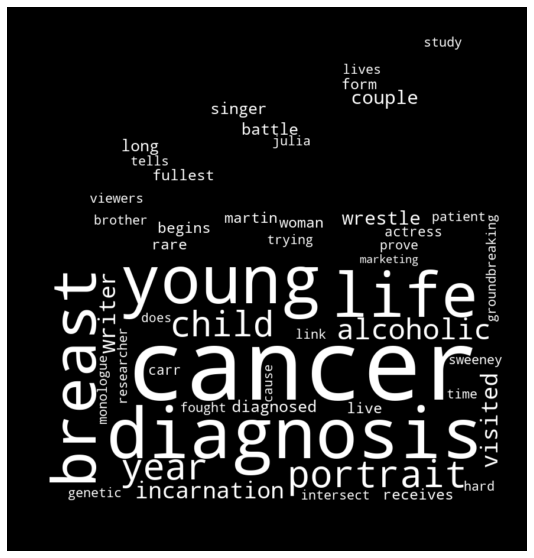

In [ ]:
#줄거리 기반 Word Cloud

title = input('Enter a title of a movie: ')
movie_index = find_movie_idx(title)

movielist = similar_movie(movie_index,rank=10)
indexlist = [ x[0] for x in movielist ]
user_df = movies_df['overview'][indexlist]

user_corpus = user_df.tolist() # pd series to list

user_tfidf = vectorizer.fit_transform(user_corpus).todense()

feature_names = vectorizer.get_feature_names()

user_words = pd.DataFrame(user_tfidf, columns=feature_names)
words_t = user_words.T.sum(axis=1)

movie_mask = np.array(Image.open("image/movie_clip.png"))
cloud = WordCloud(background_color="black", max_words=50, mask=movie_mask, color_func=lambda *args, **kwargs: "white").generate_from_frequencies(words_t)
plt.figure(figsize=(20,10))
plt.imshow(cloud, interpolation="bilinear")
plt.axis("off")
plt.show()

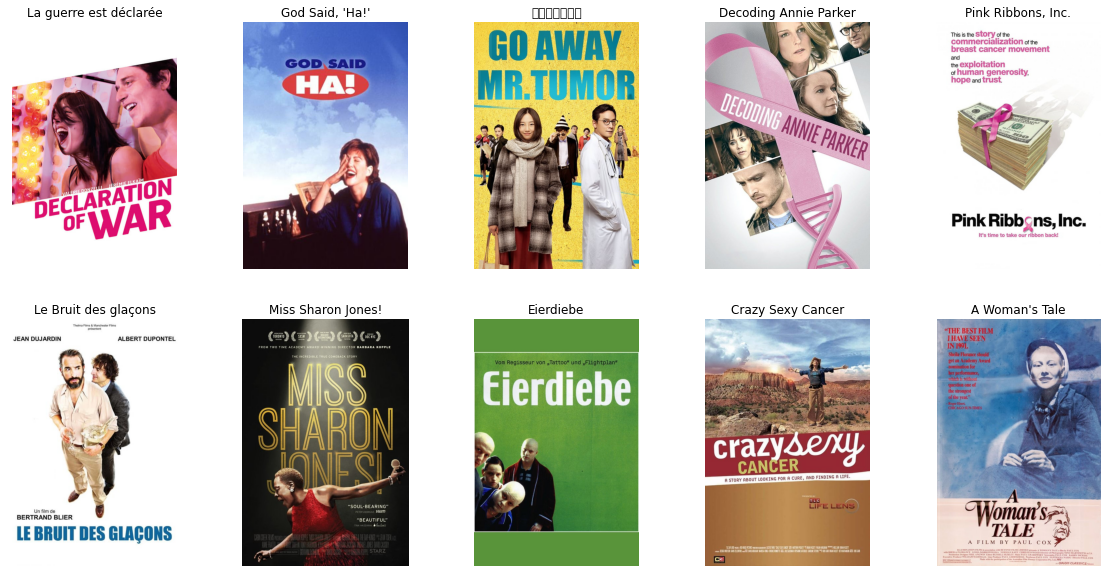

In [ ]:
#추천 영화리스트의 포스터 가져오기
from matplotlib import pyplot as plt

movie = Movie()

# create figure
fig = plt.figure(figsize=(20, 10))
  
# setting values to rows and column variables
rows = 2
columns = 5
count = 1

for index, score, film in movielist:
    search = movie.search(film)
    poster = Image.open(requests.get('https://image.tmdb.org/t/p/w500'+ search[0].poster_path, stream=True).raw)
    fig.add_subplot(rows, columns, count)
    plt.imshow(poster)
    plt.axis('off')
    plt.title(film)
    
    count +=1    

![image.png](https://github.com/jmsmg/TIL/blob/main/%ED%94%84%EB%A1%9C%EC%A0%9D%ED%8A%B8/Midproject_%EC%98%81%ED%99%94%20%EC%B6%94%EC%B2%9C%20%EC%8B%9C%EC%8A%A4%ED%85%9C/image/crawling.png?raw=1)